<a href="https://colab.research.google.com/github/ML-HW-SYS/a2/blob/draft/6_pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **6. Model Pruning**

## 6.0 Setup GDrive and Git

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Make sure your token is stored in a txt file at the location below.
# This way there is no risk that you will push it to your repo
# Never share your token with anyone, it is basically your github password!
with open('/content/gdrive/MyDrive/ece5545/token.txt') as f:
    token = f.readline().strip()
# Use another file to store your github username    
with open('/content/gdrive/MyDrive/ece5545/user.txt') as f:
    handle = f.readline().strip()

In [ ]:
# Clone your github repo
YOUR_TOKEN = token
YOUR_HANDLE = handle
BRANCH = "main"

%mkdir /content/gdrive/MyDrive/ece5545
%cd /content/gdrive/MyDrive/ece5545
!git clone https://{YOUR_TOKEN}@github.com/ML-HW-SYS/a2-{YOUR_HANDLE}.git
%cd /content/gdrive/MyDrive/ece5545/a2-{YOUR_HANDLE}
!git checkout {BRANCH}
!git pull
%cd /content/gdrive/MyDrive/ece5545

PROJECT_ROOT = f"/content/gdrive/MyDrive/ece5545/a2-{YOUR_HANDLE}"

mkdir: cannot create directory ‘/content/gdrive/MyDrive/ece5545’: File exists
/content/gdrive/MyDrive/ece5545
fatal: destination path 'a2-ethanglaser' already exists and is not an empty directory.
/content/gdrive/MyDrive/ece5545/a2-ethanglaser
M	1_audio_preprocessing.ipynb
M	2_size_estimator_and_profiler.ipynb
M	3_training_and_analysis.ipynb
M	4_model_conversion.ipynb
M	5_quantization.ipynb
M	6_pruning.ipynb
M	src/train_val_test_utils.py
Already on 'main'
Your branch is up to date with 'origin/main'.
Already up to date.
/content/gdrive/MyDrive/ece5545


In [ ]:
# This extension reloads all imports before running each cell
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### GPU: Ensure you are running the GPU runtime type:
1.   Click "Runtime" on top banner
2.   Select "Change runtime type"
3.   Under "Hardware accelarator" select "GPU" and save

### Install required packages

In [ ]:
!pip install torchaudio

### Import code dependencies

In [ ]:
# Import libraries 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils.prune as prune

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import copy

import time

import sys

# Adding assignment1 to the system path-- make sure this matches your git directory
sys.path.insert(0, PROJECT_ROOT)

# Import data_proc to use data processing functions
import src.data_proc as data_proc

# Import constants to use constants defined for training
from src.constants import *

# TensorBoard
from torch.utils.tensorboard import SummaryWriter

# Set random seed
# Make sure the shuffling and picking is deterministic
# Note that different value of random_seed may change rate of variation in loss/accuracy during training
# Using the same random seed value every time you rerun the notebook will 
# reproduce the training and testing results  
random_seed = 0
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

## 6.1 Prepare for Training



In [ ]:
# Create audio_processor
# DATASET_DIR is defined in constants.py
audio_processor = data_proc.AudioProcessor()
print("Audio_processor created")

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} to run the training scrpit.')

# Define data loaders
from src.loaders import make_data_loaders
data_loaders = make_data_loaders(audio_processor, device)
train_loader = data_loaders['training']
test_loader = data_loaders['testing']
valid_loader = data_loaders['validation']

# Create a full precision (float32) TinyConv model
from src.networks import TinyConv
model_fp32 = TinyConv(model_settings=audio_processor.model_settings, \
    n_input=1, n_output=audio_processor.num_labels)

model_fp32

Audio_processor created
Using cuda to run the training scrpit.
Train size: 10556 Val size: 1333 Test size: 1368


TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [ ]:
!ls {TORCH_DIR}

 fp32_checkpoint.pt	       quant_checkpoint2.pt   quant_checkpoint8.pt
 fp32_finetune_checkpoint.pt   quant_checkpoint4.pt   quant_checkpoint.pt
'(QAT4bit)quant_0.pt'	       quant_checkpoint6.pt


### **TODO: Replace the torch_path model with the model you created in the last section.** 

You can find the name of your file in `TORCH_DIR` under the folder icon to the left. (Or from running the tab above).

In [ ]:
# TODO: Replace me!
torch_path = os.path.join(TORCH_DIR, "../../tinyconv_float32_init_seed0_90.42%_0.pt")

# Load model
model_fp32.load_state_dict(torch.load(torch_path))
model_fp32_orig = copy.deepcopy(model_fp32)
model_fp32, model_fp32_orig

(TinyConv(
   (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
   (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc_reshape): Reshape(output_shape=(-1, 4000))
   (fc): Linear(in_features=4000, out_features=4, bias=True)
   (softmax): Softmax(dim=1)
 ), TinyConv(
   (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
   (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc_reshape): Reshape(output_shape=(-1, 4000))
   (fc): Linear(in_features=4000, out_features=4, bias=True)
   (softmax): Softmax(dim=1)
 ))

## 6.2 Structured Pruning

In this section, you will try to conduct structured pruning on the TinyConv model and explore its effect on performance.
In this notebook, you will be only given minimum scarfolding code. Please take advantages of the code in previous section to faciliate.

Following link will be helpful:
[torch.nn.utils.prune.LnStructured](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.LnStructured.html?highlight=prune#torch.nn.utils.prune.LnStructured.prune)
[Torch pruning tutorial](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html?highlight=prune)

Train size: 10556 Val size: 1333 Test size: 1368
[torch.Size([8, 1, 10, 8]), torch.Size([8]), torch.Size([4, 4000]), torch.Size([4])]
[]
{'conv_reshape': {'bias': 0}, 'conv': {'bias': 4000, 'weight': 1280000}, 'relu': {'bias': 0}, 'fc': {'bias': 4, 'weight': 32000}, 'softmax': {'bias': 0}, '': {'bias': 0}}
proportion 0 params 16652
flops 1316004
accuracy 0.9035087719298246


  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 1
Train Acc Epoch 1 = 91.21%, Val Acc Epoch 1 = 91.75%, Train loss = 0.315
EPOCH 2
Train Acc Epoch 2 = 91.85%, Val Acc Epoch 2 = 91.67%, Train loss = 0.313
EPOCH 3
Train Acc Epoch 3 = 91.78%, Val Acc Epoch 3 = 91.6%, Train loss = 0.299
EPOCH 4
Train Acc Epoch 4 = 91.89%, Val Acc Epoch 4 = 91.97%, Train loss = 0.29
EPOCH 5
Train Acc Epoch 5 = 91.96%, Val Acc Epoch 5 = 92.57%, Train loss = 0.298
EPOCH 6
Train Acc Epoch 6 = 92.24%, Val Acc Epoch 6 = 91.82%, Train loss = 0.296
EPOCH 7
Train Acc Epoch 7 = 92.18%, Val Acc Epoch 7 = 92.57%, Train loss = 0.294
EPOCH 8
Train Acc Epoch 8 = 92.15%, Val Acc Epoch 8 = 91.97%, Train loss = 0.296
EPOCH 9
Train Acc Epoch 9 = 91.82%, Val Acc Epoch 9 = 92.5%, Train loss = 0.29
EPOCH 10
Train Acc Epoch 10 = 91.6%, Val Acc Epoch 10 = 92.35%, Train loss = 0.287
Fine tuned accuracy 0.9144736842105263
[torch.Size([8, 1, 10, 8]), torch.Size([8]), torch.Size([4, 4000]), torch.Size([4])]
[6]
{'conv_reshape': {'bias': 0}, 'conv': {'bias': 3500, 'weight': 1

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 1
Train Acc Epoch 1 = 89.59%, Val Acc Epoch 1 = 90.55%, Train loss = 0.39
EPOCH 2
Train Acc Epoch 2 = 89.72%, Val Acc Epoch 2 = 90.62%, Train loss = 0.364
EPOCH 3
Train Acc Epoch 3 = 89.45%, Val Acc Epoch 3 = 90.4%, Train loss = 0.362
EPOCH 4
Train Acc Epoch 4 = 89.74%, Val Acc Epoch 4 = 90.62%, Train loss = 0.362
EPOCH 5
Train Acc Epoch 5 = 89.85%, Val Acc Epoch 5 = 90.77%, Train loss = 0.355
EPOCH 6
Train Acc Epoch 6 = 90.5%, Val Acc Epoch 6 = 90.32%, Train loss = 0.347
EPOCH 7
Train Acc Epoch 7 = 90.41%, Val Acc Epoch 7 = 91.15%, Train loss = 0.343
EPOCH 8
Train Acc Epoch 8 = 90.08%, Val Acc Epoch 8 = 91.15%, Train loss = 0.335
EPOCH 9
Train Acc Epoch 9 = 90.36%, Val Acc Epoch 9 = 90.85%, Train loss = 0.349
EPOCH 10
Train Acc Epoch 10 = 89.97%, Val Acc Epoch 10 = 90.4%, Train loss = 0.342
Fine tuned accuracy 0.8983918128654971
[torch.Size([8, 1, 10, 8]), torch.Size([8]), torch.Size([4, 4000]), torch.Size([4])]
[0, 6]
{'conv_reshape': {'bias': 0}, 'conv': {'bias': 3000, 'weight

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 1
Train Acc Epoch 1 = 87.82%, Val Acc Epoch 1 = 88.22%, Train loss = 0.43
EPOCH 2
Train Acc Epoch 2 = 87.96%, Val Acc Epoch 2 = 88.3%, Train loss = 0.408
EPOCH 3
Train Acc Epoch 3 = 88.14%, Val Acc Epoch 3 = 89.12%, Train loss = 0.39
EPOCH 4
Train Acc Epoch 4 = 88.31%, Val Acc Epoch 4 = 89.2%, Train loss = 0.404
EPOCH 5
Train Acc Epoch 5 = 88.44%, Val Acc Epoch 5 = 88.52%, Train loss = 0.396
EPOCH 6
Train Acc Epoch 6 = 88.84%, Val Acc Epoch 6 = 88.9%, Train loss = 0.392
EPOCH 7
Train Acc Epoch 7 = 88.87%, Val Acc Epoch 7 = 89.2%, Train loss = 0.394
EPOCH 8
Train Acc Epoch 8 = 88.44%, Val Acc Epoch 8 = 89.12%, Train loss = 0.382
EPOCH 9
Train Acc Epoch 9 = 88.93%, Val Acc Epoch 9 = 88.97%, Train loss = 0.371
EPOCH 10
Train Acc Epoch 10 = 88.41%, Val Acc Epoch 10 = 89.35%, Train loss = 0.379
Fine tuned accuracy 0.8786549707602339
[torch.Size([8, 1, 10, 8]), torch.Size([8]), torch.Size([4, 4000]), torch.Size([4])]
[0, 3, 6]
{'conv_reshape': {'bias': 0}, 'conv': {'bias': 2500, 'weigh

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 1
Train Acc Epoch 1 = 84.78%, Val Acc Epoch 1 = 84.77%, Train loss = 0.554
EPOCH 2
Train Acc Epoch 2 = 86.05%, Val Acc Epoch 2 = 85.45%, Train loss = 0.494
EPOCH 3
Train Acc Epoch 3 = 85.96%, Val Acc Epoch 3 = 85.97%, Train loss = 0.47
EPOCH 4
Train Acc Epoch 4 = 86.2%, Val Acc Epoch 4 = 87.77%, Train loss = 0.453
EPOCH 5
Train Acc Epoch 5 = 87.31%, Val Acc Epoch 5 = 87.85%, Train loss = 0.448
EPOCH 6
Train Acc Epoch 6 = 87.29%, Val Acc Epoch 6 = 87.7%, Train loss = 0.431
EPOCH 7
Train Acc Epoch 7 = 87.32%, Val Acc Epoch 7 = 88.0%, Train loss = 0.431
EPOCH 8
Train Acc Epoch 8 = 87.32%, Val Acc Epoch 8 = 88.45%, Train loss = 0.434
EPOCH 9
Train Acc Epoch 9 = 87.94%, Val Acc Epoch 9 = 88.15%, Train loss = 0.43
EPOCH 10
Train Acc Epoch 10 = 87.78%, Val Acc Epoch 10 = 88.3%, Train loss = 0.407
Fine tuned accuracy 0.8859649122807017
[torch.Size([8, 1, 10, 8]), torch.Size([8]), torch.Size([4, 4000]), torch.Size([4])]
[0, 2, 3, 6]
{'conv_reshape': {'bias': 0}, 'conv': {'bias': 2000, 'we

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 1
Train Acc Epoch 1 = 80.65%, Val Acc Epoch 1 = 81.85%, Train loss = 0.735
EPOCH 2
Train Acc Epoch 2 = 83.01%, Val Acc Epoch 2 = 84.17%, Train loss = 0.603
EPOCH 3
Train Acc Epoch 3 = 83.99%, Val Acc Epoch 3 = 85.75%, Train loss = 0.564
EPOCH 4
Train Acc Epoch 4 = 84.54%, Val Acc Epoch 4 = 85.07%, Train loss = 0.543
EPOCH 5
Train Acc Epoch 5 = 84.68%, Val Acc Epoch 5 = 86.8%, Train loss = 0.517
EPOCH 6
Train Acc Epoch 6 = 85.42%, Val Acc Epoch 6 = 87.17%, Train loss = 0.509
EPOCH 7
Train Acc Epoch 7 = 85.69%, Val Acc Epoch 7 = 87.32%, Train loss = 0.501
EPOCH 8
Train Acc Epoch 8 = 86.12%, Val Acc Epoch 8 = 86.12%, Train loss = 0.472
EPOCH 9
Train Acc Epoch 9 = 86.38%, Val Acc Epoch 9 = 87.55%, Train loss = 0.474
EPOCH 10
Train Acc Epoch 10 = 85.73%, Val Acc Epoch 10 = 87.17%, Train loss = 0.468
Fine tuned accuracy 0.8669590643274854
[torch.Size([8, 1, 10, 8]), torch.Size([8]), torch.Size([4, 4000]), torch.Size([4])]
[0, 1, 2, 3, 6]
{'conv_reshape': {'bias': 0}, 'conv': {'bias': 1

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 1
Train Acc Epoch 1 = 72.3%, Val Acc Epoch 1 = 69.62%, Train loss = 0.87
EPOCH 2
Train Acc Epoch 2 = 75.72%, Val Acc Epoch 2 = 74.34%, Train loss = 0.754
EPOCH 3
Train Acc Epoch 3 = 77.26%, Val Acc Epoch 3 = 76.89%, Train loss = 0.713
EPOCH 4
Train Acc Epoch 4 = 78.2%, Val Acc Epoch 4 = 76.59%, Train loss = 0.694
EPOCH 5
Train Acc Epoch 5 = 79.05%, Val Acc Epoch 5 = 78.24%, Train loss = 0.658
EPOCH 6
Train Acc Epoch 6 = 80.34%, Val Acc Epoch 6 = 78.77%, Train loss = 0.646
EPOCH 7
Train Acc Epoch 7 = 80.31%, Val Acc Epoch 7 = 79.37%, Train loss = 0.636
EPOCH 8
Train Acc Epoch 8 = 81.09%, Val Acc Epoch 8 = 79.74%, Train loss = 0.632
EPOCH 9
Train Acc Epoch 9 = 81.45%, Val Acc Epoch 9 = 80.57%, Train loss = 0.603
EPOCH 10
Train Acc Epoch 10 = 81.17%, Val Acc Epoch 10 = 81.55%, Train loss = 0.607
Fine tuned accuracy 0.7865497076023392
[torch.Size([8, 1, 10, 8]), torch.Size([8]), torch.Size([4, 4000]), torch.Size([4])]
[0, 1, 2, 3, 4, 6]
{'conv_reshape': {'bias': 0}, 'conv': {'bias': 

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 1
Train Acc Epoch 1 = 71.31%, Val Acc Epoch 1 = 71.94%, Train loss = 0.945
EPOCH 2
Train Acc Epoch 2 = 74.46%, Val Acc Epoch 2 = 74.42%, Train loss = 0.815
EPOCH 3
Train Acc Epoch 3 = 75.26%, Val Acc Epoch 3 = 75.54%, Train loss = 0.78
EPOCH 4
Train Acc Epoch 4 = 76.43%, Val Acc Epoch 4 = 75.24%, Train loss = 0.747
EPOCH 5
Train Acc Epoch 5 = 76.75%, Val Acc Epoch 5 = 77.94%, Train loss = 0.725
EPOCH 6
Train Acc Epoch 6 = 77.43%, Val Acc Epoch 6 = 76.07%, Train loss = 0.711
EPOCH 7
Train Acc Epoch 7 = 77.66%, Val Acc Epoch 7 = 77.57%, Train loss = 0.693
EPOCH 8
Train Acc Epoch 8 = 77.51%, Val Acc Epoch 8 = 78.02%, Train loss = 0.69
EPOCH 9
Train Acc Epoch 9 = 78.16%, Val Acc Epoch 9 = 78.39%, Train loss = 0.685
EPOCH 10
Train Acc Epoch 10 = 78.71%, Val Acc Epoch 10 = 78.32%, Train loss = 0.683
Fine tuned accuracy 0.7909356725146199
[torch.Size([8, 1, 10, 8]), torch.Size([8]), torch.Size([4, 4000]), torch.Size([4])]
[0, 1, 2, 3, 4, 6, 7]
{'conv_reshape': {'bias': 0}, 'conv': {'bia

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 1
Train Acc Epoch 1 = 64.66%, Val Acc Epoch 1 = 65.72%, Train loss = 1.016
EPOCH 2
Train Acc Epoch 2 = 66.98%, Val Acc Epoch 2 = 67.37%, Train loss = 0.98
EPOCH 3
Train Acc Epoch 3 = 68.02%, Val Acc Epoch 3 = 68.64%, Train loss = 0.969
EPOCH 4
Train Acc Epoch 4 = 69.3%, Val Acc Epoch 4 = 70.37%, Train loss = 0.943
EPOCH 5
Train Acc Epoch 5 = 70.41%, Val Acc Epoch 5 = 72.47%, Train loss = 0.924
EPOCH 6
Train Acc Epoch 6 = 70.57%, Val Acc Epoch 6 = 72.62%, Train loss = 0.909
EPOCH 7
Train Acc Epoch 7 = 71.24%, Val Acc Epoch 7 = 74.49%, Train loss = 0.905
EPOCH 8
Train Acc Epoch 8 = 71.77%, Val Acc Epoch 8 = 73.82%, Train loss = 0.892
EPOCH 9
Train Acc Epoch 9 = 71.56%, Val Acc Epoch 9 = 74.79%, Train loss = 0.888
EPOCH 10
Train Acc Epoch 10 = 72.0%, Val Acc Epoch 10 = 73.97%, Train loss = 0.882
Fine tuned accuracy 0.7207602339181286
Accuracy [0.9035087719298246, 0.8698830409356725, 0.8230994152046783, 0.7668128654970761, 0.6630116959064327, 0.5599415204678363, 0.6206140350877193, 0

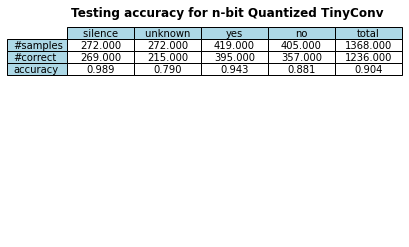

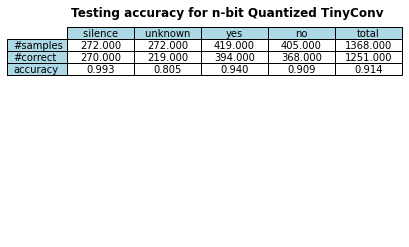

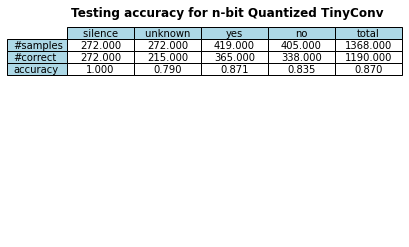

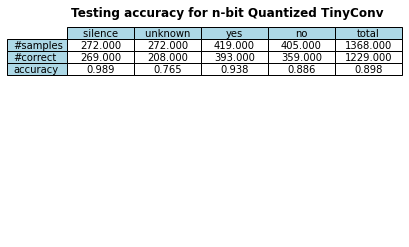

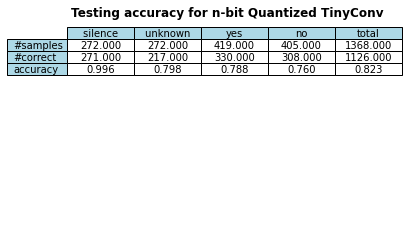

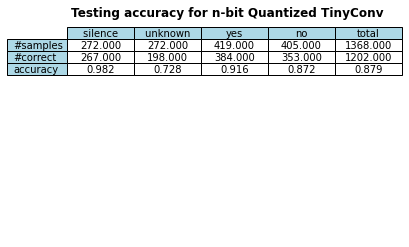

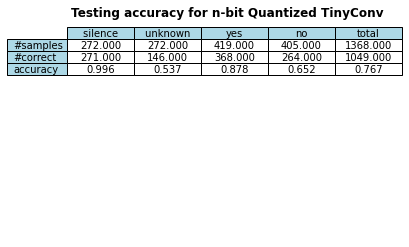

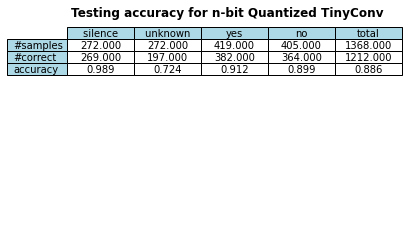

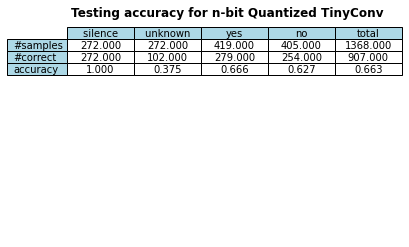

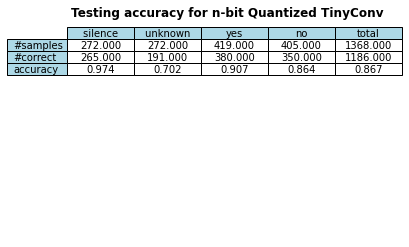

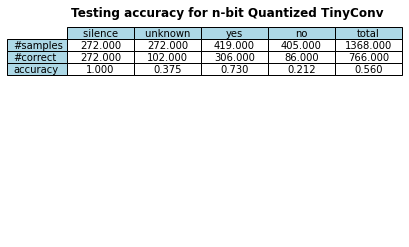

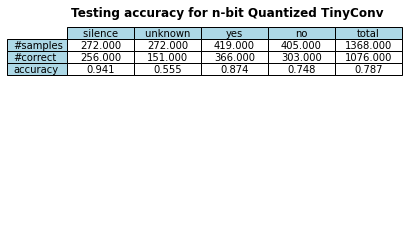

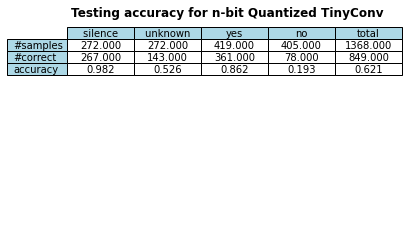

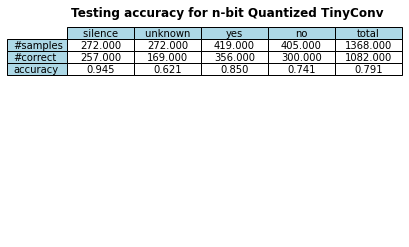

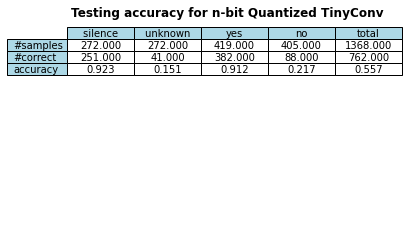

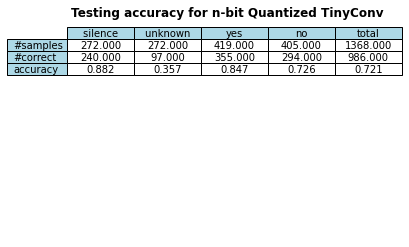

In [123]:
from torch.nn.utils import prune
from src.train_val_test_utils import plot_acc
import torch.nn as nn
from src.size_estimate import *
import torch_pruning as tp
from time import time


def prunee(model, layer_type, num_channels_remove, structured=True):
    strategy = tp.strategy.L1Strategy() # or tp.strategy.RandomStrategy()
    DG = tp.DependencyGraph()
    DG.build_dependency(model, example_inputs=torch.randn(((1, model_fp32.model_settings['fingerprint_width'], model_fp32.model_settings['spectrogram_length']))))
    pruning_idxs = strategy(model.conv.weight, amount=num_channels_remove/8.) # or manually selected pruning_idxs=[2, 6, 9, ...]
    print(pruning_idxs)
    pruning_plan = DG.get_pruning_plan( model.conv, tp.prune_conv, idxs=pruning_idxs )
    pruning_plan.exec()
    return model

test_time_data_loaders = make_data_loaders(
    audio_processor, device, 
    test_batch_size=1, valid_batch_size=1,
    num_workers=0
)

runtimes = []
baseline_accuracy = []
finetune_accuracy = []
flops = []
parameters = []

for proportion in range(8):
    current_model = copy.deepcopy(model_fp32)
    print([layer.size() for layer in list(model_fp32.parameters())])
    pruned_model = prunee(current_model, nn.Conv2d, proportion)
    flop_by_layers = flop(
        model=pruned_model, 
        input_shape=(
            1, 
            pruned_model.model_settings['fingerprint_width'], 
            pruned_model.model_settings['spectrogram_length']
        ), 
        device=device)
    print(flop_by_layers)
    print("proportion", proportion, "params", count_trainable_parameters(pruned_model))
    print("flops", sum([sum(val.values()) for val in flop_by_layers.values()]))
    flops.append(sum([sum(val.values()) for val in flop_by_layers.values()]))
    parameters.append(count_trainable_parameters(pruned_model))
    acc, runtime = plot_acc(
        test_time_data_loaders['testing'], pruned_model, audio_processor, device,
        'Testing', 'n-bit Quantized TinyConv', "float")
    print("accuracy", acc)

    baseline_accuracy.append(acc)
    runtimes.append(runtime)

    # Create optimizer
    optimizer_fp32 = create_optimizer(model=pruned_model, learning_rate=0.0001)

    checkpoint_path = os.path.join(TORCH_DIR, "pruned_finetune_checkpoint" + str(proportion) + ".pt")
    pruned_model.to(device)
    verbose = False
    log_interval = 100
    num_batches = len(train_loader)
    n_epoch = 10
    run_training(
        model=pruned_model, data_loaders=data_loaders, 
        n_epoch=n_epoch, log_interval=log_interval, 
        optimizer=optimizer_fp32, scheduler=None, 
        resume=False,
        checkpoint_path=checkpoint_path,
        verbose=verbose
    )
    ft_acc, _ = plot_acc(
        test_time_data_loaders['testing'], pruned_model, audio_processor, device,
        'Testing', 'n-bit Quantized TinyConv', "float")
    print("Fine tuned accuracy", ft_acc)
    finetune_accuracy.append(ft_acc)

print("Accuracy", baseline_accuracy)
print("Finetuned accuracy", finetune_accuracy)
print("runtimes", runtimes)
print("flops", flops)
print("params", parameters)

In [119]:
import time
from src.train_val_test_utils import train, test
from src.train_val_test_utils import create_optimizer


def run_training(model, data_loaders, n_epoch, log_interval, optimizer, scheduler=None, 
                 save_interval=1, resume=True, checkpoint_path=None, verbose=False):
    test_loader = data_loaders['testing']
    with tqdm(total=n_epoch) as pbar:
        completed_epoch = 1
        if resume:
            try:
                #continue training with previous model if one exists
                if checkpoint_path is None:
                    raise ValueError
                checkpoint = torch.load(checkpoint_path)
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                if scheduler is not None:
                    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
                completed_epoch = checkpoint["epoch"] + 1
                model.eval()
                pbar.update(completed_epoch)
            except:
                pass

        for epoch in range(completed_epoch, n_epoch + 1):
            print("EPOCH", epoch)
            train_iters = len(data_loaders['training'])
            train(model, data_loaders, optimizer, epoch, device, verbose)
            test(test_loader, model, device, 
                 epoch=None, loader_type='Test')
            
            if scheduler is not None:
                scheduler.step()
            #checkpoint the model every run
            if epoch % save_interval == 0 and checkpoint_path is not None:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None
                }, checkpoint_path)
                
            # Update epoch pbar
            pbar.update(1)

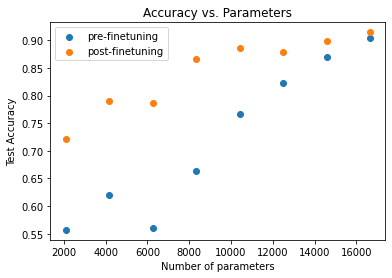

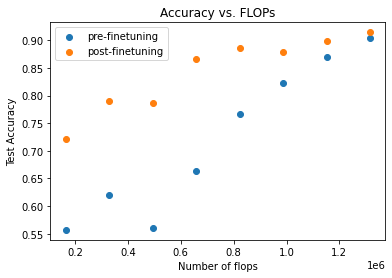

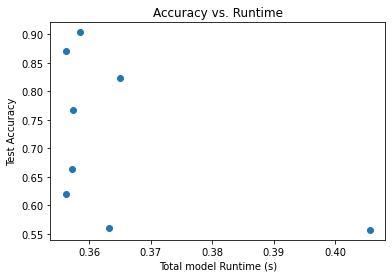

In [128]:
plt.figure()
plt.title("Accuracy vs. Parameters")
plt.xlabel("Number of parameters")
plt.ylabel("Test Accuracy")
plt.scatter(parameters, baseline_accuracy, label="pre-finetuning")
plt.scatter(parameters, finetune_accuracy, label="post-finetuning")
plt.legend()
plt.show()
plt.figure()
plt.title("Accuracy vs. FLOPs")
plt.xlabel("Number of flops")
plt.ylabel("Test Accuracy")
plt.scatter(flops, baseline_accuracy, label="pre-finetuning")
plt.scatter(flops, finetune_accuracy, label="post-finetuning")
plt.legend()
plt.show()
plt.figure()
plt.title("Accuracy vs. Runtime")
plt.xlabel("Total model Runtime (s)")
plt.ylabel("Test Accuracy")
plt.scatter(runtimes, baseline_accuracy)
plt.show()

In [145]:
# Install ONNX
!pip3 install onnx

# Install tensorflow-addons
!pip3 install tensorflow-addons
!pip3 install tensorflow-probability

# Install onnx-tensorflow
!git clone https://github.com/onnx/onnx-tensorflow.git 
!cd onnx-tensorflow && pip3 install -e . 
# NOTE THERE IS A BUG. If you try and fail to import onnx_tf then just restart 
# your runtime after cloning the repo and it should work!

!pip3 install torchaudio
# Import libraries
import sys,os

# Add path to onnx-tensorflow
sys.path.insert(0, os.path.join(PROJECT_ROOT, '../onnx-tensorflow'))
sys.path.insert(0, PROJECT_ROOT)
print(sys.path)
import onnx
import torch
import torch.nn as nn
import numpy as np
import os
import tensorflow as tf
print(f"TensorFlow Version is: {tf.__version__}")
from onnx_tf.backend import prepare

# Import constants to use constants defined for training
from src.constants import *
import src.data_proc as data_proc
TORCH_DIR = "models/torch_models"

def pytorch_to_output(model):
    file_name = 'mcu_model'
    # Create a new TinyConv model
    ONNX_PATH = os.path.join(ONNX_DIR, f'{file_name}.onnx')
    TF_PATH = os.path.join(TF_DIR, f'{file_name}')

    # Create a random input for model export
    dummy_input = torch.autograd.Variable(torch.randn(1, 1960))

    # Export model as .onnx file
    torch.onnx.export(model_fp32.cpu(), dummy_input, ONNX_PATH)

    # Load onnx model into a tensorflow model
    onnx_model = onnx.load(ONNX_PATH)
    tf_rep = prepare(onnx_model) 

    # Export model as .pb file

    tf_rep.export_graph(TF_PATH)

    FLOAT_MODEL_TFLITE = os.path.join(TFLITE_DIR, f'float_{file_name}.tflite')
    MODEL_TFLITE = os.path.join(TFLITE_DIR, f'quant_{file_name}.tflite')

    float_converter = tf.lite.TFLiteConverter.from_saved_model(TF_PATH)
    float_tflite_model = float_converter.convert()
    float_tflite_model_size = open(FLOAT_MODEL_TFLITE, "wb").write(float_tflite_model)
    print("Float model is %d bytes" % float_tflite_model_size)

    converter = tf.lite.TFLiteConverter.from_saved_model(TF_PATH)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8
    def representative_dataset_gen():
        for i in range(100):
            data, _ = audio_processor.get_data(
                1, i*1, BACKGROUND_FREQUENCY, BACKGROUND_VOLUME_RANGE, TIME_SHIFT_MS, 'testing')
            flattened_data = np.array(data.flatten(), dtype=np.float32).reshape([1, 1960])
            yield [flattened_data]
    converter.representative_dataset = representative_dataset_gen

    tflite_model = converter.convert()
    tflite_model_size = open(MODEL_TFLITE, "wb").write(tflite_model)
    print("Quantized model is %d bytes" % tflite_model_size)
    # Compute float model accuracy
    run_tflite_inference_test_set(FLOAT_MODEL_TFLITE)

    # Compute quantized model accuracy
    run_tflite_inference_test_set(MODEL_TFLITE, model_type='Quantized')
    !apt-get update && apt-get -qq install xxd

    # Replace me!
    MODEL_TFLITE = TFLITE_DIR + '/float_mcu_model.tflite' 
    MODEL_TFLITE_MICRO = MICRO_DIR+'/micro_models.cc'

    !xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
    REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')

    !sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}
    !cat {MODEL_TFLITE_MICRO}

# Helper function to run inference
def run_tflite_inference_test_set(tflite_model_path, model_type="Float"):
    # Load test data
    test_data, test_labels = audio_processor.get_data(
          -1, 0, BACKGROUND_FREQUENCY, BACKGROUND_VOLUME_RANGE,
          TIME_SHIFT_MS, 'testing')
    test_data = np.expand_dims(test_data, axis=1).astype(np.float32)

    # Initialize the interpreter
    interpreter = tf.lite.Interpreter(tflite_model_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    # For quantized models, manually quantize the input data from float to integer
    if model_type == "Quantized":
        input_scale, input_zero_point = input_details["quantization"]
        test_data = test_data / input_scale + input_zero_point
        test_data = test_data.astype(input_details["dtype"])

    # Evaluate the predictions
    correct_predictions = 0
    for i in range(len(test_data)):
        interpreter.set_tensor(input_details["index"], test_data[i])
        interpreter.invoke()
        output = interpreter.get_tensor(output_details["index"])[0]
        top_prediction = output.argmax()
        correct_predictions += (top_prediction == test_labels[i])

    print('%s model accuracy is %f%% (Number of test samples=%d)' % (
        model_type, (correct_predictions * 100) / len(test_data), len(test_data)))

fatal: destination path 'onnx-tensorflow' already exists and is not an empty directory.
Obtaining file:///content/gdrive/MyDrive/ece5545/onnx-tensorflow
  Attempting uninstall: onnx-tf
    Found existing installation: onnx-tf 1.9.0
    Can't uninstall 'onnx-tf'. No files were found to uninstall.
  Running setup.py develop for onnx-tf
['/content/gdrive/MyDrive/ece5545/a2-ethanglaser', '/content/gdrive/MyDrive/ece5545/a2-ethanglaser/../onnx-tensorflow', '/content/gdrive/MyDrive/ece5545/a2-ethanglaser', '/content/gdrive/MyDrive/ece5545/a2-ethanglaser/../onnx-tensorflow', '/content/gdrive/MyDrive/ece5545/a2-ethanglaser', '/content/gdrive/MyDrive/ece5545/a2-ethanglaser/../onnx-tensorflow', '/content/gdrive/MyDrive/ece5545/a2-ethanglaser', '/content/gdrive/MyDrive/ece5545/a2-ethanglaser/../onnx-tensorflow', '/content/gdrive/MyDrive/ece5545/a2-ethanglaser', '/content/gdrive/MyDrive/ece5545/a2-ethanglaser/../onnx-tensorflow', '/content/gdrive/MyDrive/ece5545/a2-ethanglaser', '/content/gdrive/M

In [146]:
pytorch_to_output(pruned_model)

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/ece5545/models/tf_models/mcu_model/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/ece5545/models/tf_models/mcu_model/assets


Float model is 69032 bytes


Streaming output truncated to the last 5000 lines.
  0x15, 0x36, 0x09, 0x3d, 0x67, 0xd9, 0x5e, 0xbd, 0xac, 0xe6, 0xac, 0xbd,
  0xb4, 0xbf, 0xae, 0xbd, 0xc0, 0xd6, 0xd1, 0xbc, 0xa3, 0x98, 0x39, 0x3b,
  0xc1, 0xc2, 0x92, 0xbc, 0x0e, 0x70, 0xce, 0xbb, 0x63, 0xd1, 0x2c, 0x3d,
  0x38, 0xae, 0xe4, 0xbd, 0xea, 0xd9, 0x03, 0xbd, 0x0e, 0xc7, 0xea, 0xbd,
  0xce, 0x06, 0x23, 0xbe, 0xd0, 0xec, 0xe5, 0xbd, 0x1a, 0x31, 0x0a, 0xbe,
  0x28, 0x55, 0xb5, 0xbd, 0x24, 0x1e, 0x90, 0xbc, 0xa3, 0xf2, 0xa1, 0x3c,
  0xa0, 0xe5, 0x8c, 0xbd, 0x78, 0x30, 0xf1, 0xbc, 0x81, 0x64, 0xaa, 0x3c,
  0x5e, 0x2d, 0xdc, 0xbd, 0x34, 0xd9, 0x9a, 0xbd, 0x81, 0x59, 0x51, 0xbd,
  0x87, 0x1e, 0xc1, 0xbd, 0x2f, 0xf9, 0x85, 0xbd, 0xcf, 0x46, 0x2e, 0x3d,
  0x60, 0x9d, 0x2e, 0x3c, 0xcd, 0x01, 0x3b, 0x3c, 0x8f, 0xa0, 0xe0, 0xbd,
  0x54, 0x43, 0x5f, 0xbc, 0x30, 0xaf, 0x09, 0xbe, 0x39, 0xc6, 0xb0, 0xbd,
  0x7e, 0xc3, 0xa1, 0xbd, 0xc8, 0x2b, 0xd9, 0xbd, 0x46, 0xfa, 0x94, 0xbd,
  0x00, 0x0c, 0xa3, 0xbd, 0x42, 0x34, 0xce, 0x3b, 0xe9, 0x7a,

## 6.3 Unstructured Pruning

In this section, you will perform unstructured pruning on the TinyConv model and explore its effect on performance.

Following link will be helpful:
1. [torch.nn.utils.prune.l1_unstructured](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.l1_unstructured.html?highlight=unstructured#torch.nn.utils.prune.l1_unstructured)

2. [torch.nn.utils.prune.random_unstructured](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.random_unstructured.html?highlight=unstructured#torch.nn.utils.prune.random_unstructured)

2. [Torch pruning tutorial](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html?highlight=prune)

accuracy 0.9042397660818714


  0%|          | 0/8 [00:00<?, ?it/s]

EPOCH 1
Train Acc Epoch 1 = 90.34%, Val Acc Epoch 1 = 90.7%, Train loss = 0.339
EPOCH 2
Train Acc Epoch 2 = 90.21%, Val Acc Epoch 2 = 90.77%, Train loss = 0.334
EPOCH 3
Train Acc Epoch 3 = 90.3%, Val Acc Epoch 3 = 90.47%, Train loss = 0.327
EPOCH 4
Train Acc Epoch 4 = 90.56%, Val Acc Epoch 4 = 91.22%, Train loss = 0.334
EPOCH 5
Train Acc Epoch 5 = 90.16%, Val Acc Epoch 5 = 90.4%, Train loss = 0.335
EPOCH 6
Train Acc Epoch 6 = 90.12%, Val Acc Epoch 6 = 90.25%, Train loss = 0.335
EPOCH 7
Train Acc Epoch 7 = 90.64%, Val Acc Epoch 7 = 90.7%, Train loss = 0.321
EPOCH 8
Train Acc Epoch 8 = 90.44%, Val Acc Epoch 8 = 90.85%, Train loss = 0.331
ft accuracy 0.7207602339181286
proportion 7 params 2085.0
accuracy 0.902046783625731


  0%|          | 0/8 [00:00<?, ?it/s]

EPOCH 1
Train Acc Epoch 1 = 90.57%, Val Acc Epoch 1 = 90.17%, Train loss = 0.35
EPOCH 2
Train Acc Epoch 2 = 90.61%, Val Acc Epoch 2 = 90.85%, Train loss = 0.348
EPOCH 3
Train Acc Epoch 3 = 90.49%, Val Acc Epoch 3 = 90.85%, Train loss = 0.336
EPOCH 4
Train Acc Epoch 4 = 90.06%, Val Acc Epoch 4 = 90.85%, Train loss = 0.34
EPOCH 5
Train Acc Epoch 5 = 90.22%, Val Acc Epoch 5 = 91.6%, Train loss = 0.343
EPOCH 6
Train Acc Epoch 6 = 90.72%, Val Acc Epoch 6 = 90.02%, Train loss = 0.35
EPOCH 7
Train Acc Epoch 7 = 90.58%, Val Acc Epoch 7 = 90.55%, Train loss = 0.324
EPOCH 8
Train Acc Epoch 8 = 90.43%, Val Acc Epoch 8 = 91.15%, Train loss = 0.326
ft accuracy 0.7207602339181286
proportion 7 params 1824.375
accuracy 0.8947368421052632


  0%|          | 0/8 [00:00<?, ?it/s]

EPOCH 1
Train Acc Epoch 1 = 90.25%, Val Acc Epoch 1 = 89.12%, Train loss = 0.377
EPOCH 2
Train Acc Epoch 2 = 89.96%, Val Acc Epoch 2 = 90.17%, Train loss = 0.363
EPOCH 3
Train Acc Epoch 3 = 90.32%, Val Acc Epoch 3 = 91.07%, Train loss = 0.36
EPOCH 4
Train Acc Epoch 4 = 90.06%, Val Acc Epoch 4 = 90.85%, Train loss = 0.363
EPOCH 5
Train Acc Epoch 5 = 90.55%, Val Acc Epoch 5 = 90.02%, Train loss = 0.362
EPOCH 6
Train Acc Epoch 6 = 90.08%, Val Acc Epoch 6 = 90.85%, Train loss = 0.362
EPOCH 7
Train Acc Epoch 7 = 90.37%, Val Acc Epoch 7 = 90.55%, Train loss = 0.352
EPOCH 8
Train Acc Epoch 8 = 90.16%, Val Acc Epoch 8 = 91.45%, Train loss = 0.371
ft accuracy 0.7207602339181286
proportion 7 params 1563.75
accuracy 0.8640350877192983


  0%|          | 0/8 [00:00<?, ?it/s]

EPOCH 1
Train Acc Epoch 1 = 87.57%, Val Acc Epoch 1 = 87.4%, Train loss = 0.532
EPOCH 2
Train Acc Epoch 2 = 86.88%, Val Acc Epoch 2 = 87.47%, Train loss = 0.534
EPOCH 3
Train Acc Epoch 3 = 87.1%, Val Acc Epoch 3 = 86.35%, Train loss = 0.543
EPOCH 4
Train Acc Epoch 4 = 86.58%, Val Acc Epoch 4 = 87.02%, Train loss = 0.554
EPOCH 5
Train Acc Epoch 5 = 87.43%, Val Acc Epoch 5 = 88.07%, Train loss = 0.527
EPOCH 6
Train Acc Epoch 6 = 86.84%, Val Acc Epoch 6 = 87.32%, Train loss = 0.555
EPOCH 7
Train Acc Epoch 7 = 86.99%, Val Acc Epoch 7 = 87.17%, Train loss = 0.525
EPOCH 8
Train Acc Epoch 8 = 87.17%, Val Acc Epoch 8 = 87.7%, Train loss = 0.536
ft accuracy 0.7207602339181286
proportion 7 params 1303.125
accuracy 0.8135964912280702


  0%|          | 0/8 [00:00<?, ?it/s]

EPOCH 1
Train Acc Epoch 1 = 80.97%, Val Acc Epoch 1 = 81.55%, Train loss = 0.818
EPOCH 2
Train Acc Epoch 2 = 81.43%, Val Acc Epoch 2 = 81.92%, Train loss = 0.832
EPOCH 3
Train Acc Epoch 3 = 81.39%, Val Acc Epoch 3 = 82.75%, Train loss = 0.83
EPOCH 4
Train Acc Epoch 4 = 81.26%, Val Acc Epoch 4 = 82.0%, Train loss = 0.829
EPOCH 5
Train Acc Epoch 5 = 81.14%, Val Acc Epoch 5 = 81.47%, Train loss = 0.814
EPOCH 6
Train Acc Epoch 6 = 81.21%, Val Acc Epoch 6 = 82.0%, Train loss = 0.805
EPOCH 7
Train Acc Epoch 7 = 81.13%, Val Acc Epoch 7 = 81.62%, Train loss = 0.813
EPOCH 8
Train Acc Epoch 8 = 81.1%, Val Acc Epoch 8 = 81.55%, Train loss = 0.825
ft accuracy 0.7207602339181286
proportion 7 params 1042.5
accuracy 0.5197368421052632


  0%|          | 0/8 [00:00<?, ?it/s]

EPOCH 1
Train Acc Epoch 1 = 47.32%, Val Acc Epoch 1 = 49.81%, Train loss = 2.903
EPOCH 2
Train Acc Epoch 2 = 47.36%, Val Acc Epoch 2 = 50.94%, Train loss = 2.834
EPOCH 3
Train Acc Epoch 3 = 48.18%, Val Acc Epoch 3 = 48.76%, Train loss = 2.852
EPOCH 4
Train Acc Epoch 4 = 47.8%, Val Acc Epoch 4 = 51.09%, Train loss = 2.849
EPOCH 5
Train Acc Epoch 5 = 47.42%, Val Acc Epoch 5 = 49.14%, Train loss = 2.858
EPOCH 6
Train Acc Epoch 6 = 47.68%, Val Acc Epoch 6 = 49.21%, Train loss = 2.881
EPOCH 7
Train Acc Epoch 7 = 47.21%, Val Acc Epoch 7 = 49.66%, Train loss = 2.851
EPOCH 8
Train Acc Epoch 8 = 47.9%, Val Acc Epoch 8 = 49.36%, Train loss = 2.859
ft accuracy 0.7207602339181286
proportion 7 params 781.875
accuracy 0.40789473684210525


  0%|          | 0/8 [00:00<?, ?it/s]

EPOCH 1
Train Acc Epoch 1 = 35.04%, Val Acc Epoch 1 = 40.66%, Train loss = 6.609
EPOCH 2
Train Acc Epoch 2 = 35.42%, Val Acc Epoch 2 = 39.31%, Train loss = 6.679
EPOCH 3
Train Acc Epoch 3 = 35.51%, Val Acc Epoch 3 = 39.98%, Train loss = 6.487
EPOCH 4
Train Acc Epoch 4 = 35.3%, Val Acc Epoch 4 = 39.61%, Train loss = 6.48
EPOCH 5
Train Acc Epoch 5 = 35.59%, Val Acc Epoch 5 = 39.98%, Train loss = 6.61
EPOCH 6
Train Acc Epoch 6 = 35.44%, Val Acc Epoch 6 = 39.01%, Train loss = 6.718
EPOCH 7
Train Acc Epoch 7 = 34.92%, Val Acc Epoch 7 = 39.53%, Train loss = 6.564
EPOCH 8
Train Acc Epoch 8 = 35.35%, Val Acc Epoch 8 = 39.83%, Train loss = 6.479
ft accuracy 0.7207602339181286
proportion 7 params 521.25
accuracy 0.52046783625731


  0%|          | 0/8 [00:00<?, ?it/s]

EPOCH 1
Train Acc Epoch 1 = 47.75%, Val Acc Epoch 1 = 49.89%, Train loss = 2.976
EPOCH 2
Train Acc Epoch 2 = 47.57%, Val Acc Epoch 2 = 49.66%, Train loss = 2.942
EPOCH 3
Train Acc Epoch 3 = 46.07%, Val Acc Epoch 3 = 51.16%, Train loss = 2.902
EPOCH 4
Train Acc Epoch 4 = 47.03%, Val Acc Epoch 4 = 49.81%, Train loss = 2.918
EPOCH 5
Train Acc Epoch 5 = 46.68%, Val Acc Epoch 5 = 50.49%, Train loss = 2.956
EPOCH 6
Train Acc Epoch 6 = 46.25%, Val Acc Epoch 6 = 50.56%, Train loss = 2.95
EPOCH 7
Train Acc Epoch 7 = 45.97%, Val Acc Epoch 7 = 51.54%, Train loss = 2.918
EPOCH 8
Train Acc Epoch 8 = 46.21%, Val Acc Epoch 8 = 50.79%, Train loss = 2.898
ft accuracy 0.7207602339181286
proportion 7 params 260.625
[0.9042397660818714, 0.902046783625731, 0.8947368421052632, 0.8640350877192983, 0.8135964912280702, 0.5197368421052632, 0.40789473684210525, 0.52046783625731] [0.89546783625731, 0.9027777777777778, 0.8940058479532164, 0.8669590643274854, 0.8135964912280702, 0.5153508771929824, 0.40423976608187

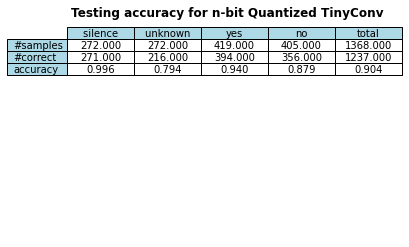

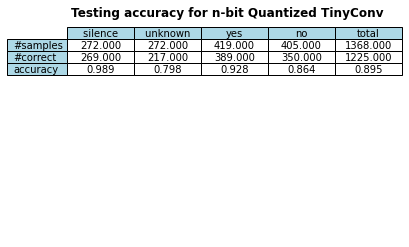

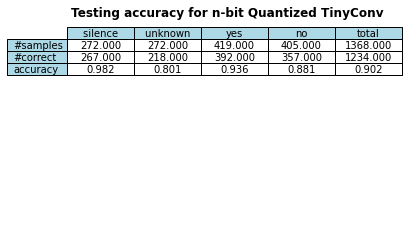

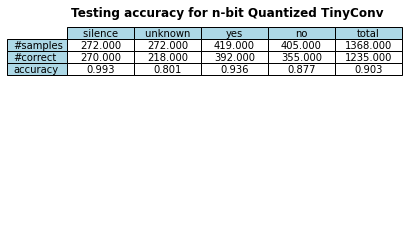

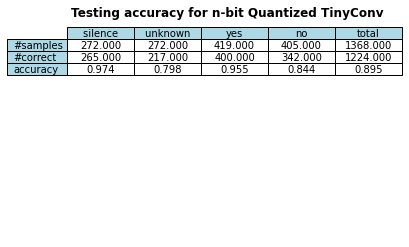

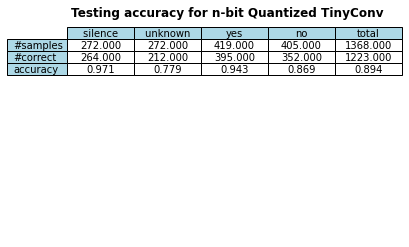

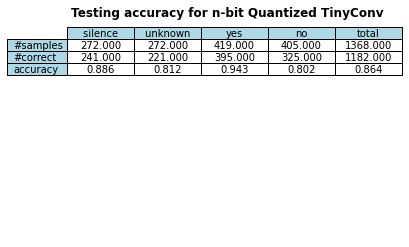

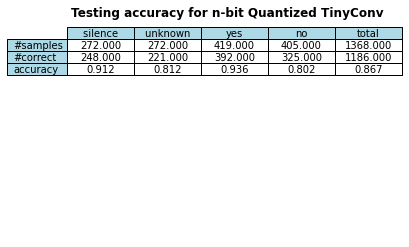

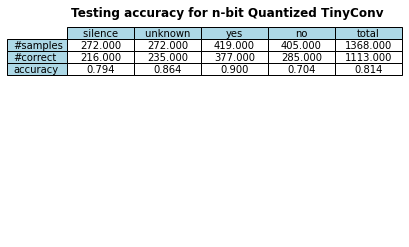

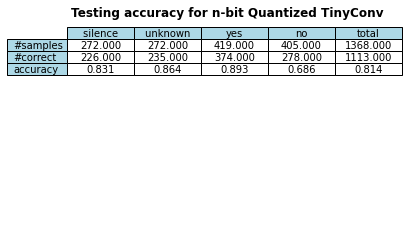

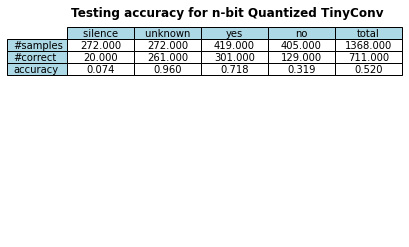

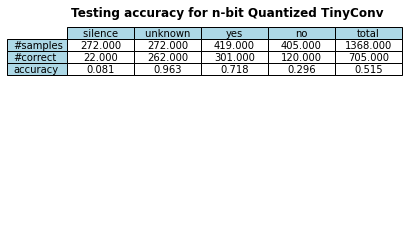

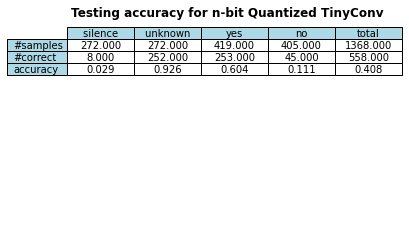

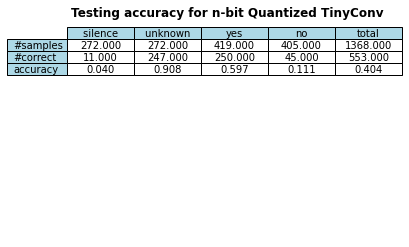

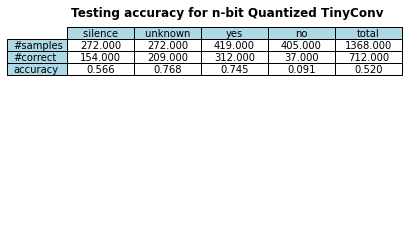

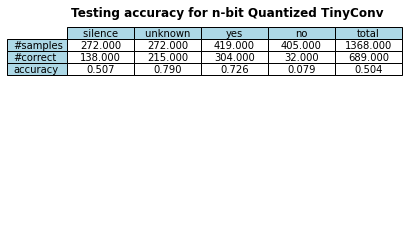

In [137]:
from torch.nn.utils import prune
import torch.nn as nn

def prune_model_l1_unstructured(model, layer_type, proportion):
    for module in model.modules():
        if isinstance(module, layer_type):
            prune.l1_unstructured(module, 'weight', proportion)
            prune.remove(module, 'weight')
    return model

accs = []
ft_accs = []
counts = []
for ratio in range(8):
    actual_ratio = ratio / 8.
    current_model = copy.deepcopy(model_fp32)
    prune_model_l1_unstructured(current_model, nn.Conv2d, actual_ratio)
    acc, _ = plot_acc(
        test_time_data_loaders['testing'], current_model, audio_processor, device,
        'Testing', 'n-bit Quantized TinyConv', "float")
    print("accuracy", acc)

    optimizer_fp32 = create_optimizer(model=pruned_model, learning_rate=0.0001)

    checkpoint_path = os.path.join(TORCH_DIR, "pruned_unstructured_finetune_checkpoint" + str(ratio) + ".pt")
    pruned_model.to(device)
    verbose = False
    log_interval = 100
    num_batches = len(train_loader)
    n_epoch = 8
    run_training(
        model=current_model, data_loaders=data_loaders, 
        n_epoch=n_epoch, log_interval=log_interval, 
        optimizer=optimizer_fp32, scheduler=None, 
        resume=False,
        checkpoint_path=checkpoint_path,
        verbose=verbose
    )
    tf_acc, _ = plot_acc(
        test_time_data_loaders['testing'], current_model, audio_processor, device,
        'Testing', 'n-bit Quantized TinyConv', "float")
    print("ft accuracy", ft_acc)
    print("proportion", proportion, "params", (1. - actual_ratio) * count_trainable_parameters(pruned_model))
    accs.append(acc)
    ft_accs.append(tf_acc)
    counts.append((1. - actual_ratio) * count_trainable_parameters(pruned_model))

print(accs, ft_accs, counts)



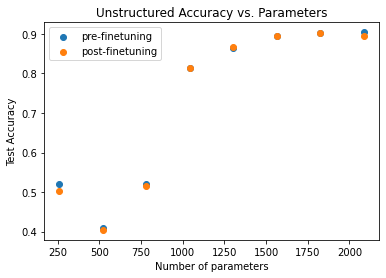

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [138]:
plt.figure()
plt.title("Unstructured Accuracy vs. Parameters")
plt.xlabel("Number of parameters")
plt.ylabel("Test Accuracy")
plt.scatter(counts, accs, label="pre-finetuning")
plt.scatter(counts, ft_accs, label="post-finetuning")
plt.legend()
plt.show()
plt.figure()